In [1]:
import sys
import importlib

sys.path.append("../")

from src import utils
from src.utils import *

from src import graph_utils
from src import inpaint_utils
from src import fiberatlas_utils

## Goal

The goal of this notebook is to do inpainting. Allowing for negative weightings of bundle to generate bundles, and allowing as well negatively connected bundles to exist

## Description


In [20]:
connFilename = '../../atlas_data/fiber_atlas/probconnatlas/wm.connatlas.scale1.h5'
hf = h5py.File(connFilename, 'r')

centers = np.array(hf.get('header').get('gmcoords'))
nsubject = hf.get('header').get('nsubjects')[()]
dim = hf.get('header').get('dim')[()]
fiber_affine = hf.get('header').get('affine')[()]

gmregions_names = hf.get('header').get('gmregions')[()]
nb_regions = gmregions_names.shape[0]

# NOTE; use the masks if necessary when 
# we select too much bundles for reconstruction
gm_mask_subj = nib.load('../../atlas_data/moviedata_fMRI_eg/gm_mask_subj7.nii').get_fdata() 
wm_mask_subj = (gm_mask_subj + 1) % 2


consistency_view = fiberatlas_utils.get_aggprop(hf, 'consistency')
length_view = fiberatlas_utils.get_aggprop(hf, 'length')
nbStlines_view = fiberatlas_utils.get_aggprop(hf, 'numbStlines')
nb_regions = consistency_view.shape[0]

region_of_interest = ['ctx-rh-posteriorcingulate', 'ctx-lh-posteriorcingulate']
index_of_interest = [np.where(gmregions_names.astype(str) == r)[0][0] 
                     for r in region_of_interest]

index_of_interest = np.array(index_of_interest)
gmregions_names[index_of_interest]

array([b'ctx-rh-posteriorcingulate', b'ctx-lh-posteriorcingulate'],
      dtype='|S49')

#### Compute the pcc  with inpainting models

In [644]:
### Compute the pcc seed connectivity
# Load the rest fmri in MNI space volumes
ftimecourse = nib.load('../atlas_data/rstfMRI_eg/movie_group_fmri.nii').get_fdata()

connFilename = '../atlas_data/fiber_atlas/probconnatlas/wm.connatlas.scale1.h5'
hf = h5py.File(connFilename, 'r')

centers = np.array(hf.get('header').get('gmcoords'))

gmregions_names = hf.get('header').get('gmregions')[()]
# use the masks if necessary when we select too much bundles for reconstruction
gm_mask_subj = nib.load('../atlas_data/rstfMRI_eg/gm_mask_subj7.nii').get_fdata()
wm_mask_subj = (gm_mask_subj + 1) % 2

region_of_interest = ['ctx-rh-posteriorcingulate', 'ctx-lh-posteriorcingulate']
index_of_interest = [np.where(gmregions_names.astype(str) == r)[0][0] 
                     for r in region_of_interest]

index_of_interest = np.array(index_of_interest)

# Visualize the corresponding probabilstic voxels for this region
root = '../atlas_data/fiber_atlas/yasser_datacomp/volspams_compress/'

atlas_of_interest = 'compresslausanne2018.scale1.sym.corrected.ctx+subc.volspams.nii.gz'

prob_regions, prob_affine = (nib.load(root + atlas_of_interest).get_fdata(), nib.load(root + atlas_of_interest).affine)

# threshold the prob_regions into binary mask
thresh = 0.1  # empirically chosen thresh to have at least 3 subjects overlap on that region
mask_regions = (prob_regions > thresh).astype(float)

rmask_regions_nifti = nimg.resample_to_img(nib.Nifti1Image(mask_regions, affine=prob_affine), 
                                           nib.Nifti1Image(ftimecourse[:,:,:,0], affine=rest_affine), interpolation = 'nearest')
rmask_regions = rmask_regions_nifti.get_fdata()

In [645]:
from scipy.ndimage import gaussian_filter1d

tmp = np.concatenate([ftimecourse[rmask_regions[:,:,:,k + 1].astype(bool)] for k in index_of_interest])
movie_mean = np.mean([gaussian_filter1d(tmp[k],1.2) for k in range(len(tmp))],axis=0)

tmparray_lasso = []
for k in tqdm(range(ftimecourse.shape[-1])):
    tmp_inpainted, tmp_inpainted2 = interpolate_activity(fmri_coords, bundles_labels, bundle_opt[k], vdim, wmmask=wm_mask_subj, normalizing=True, verbose=False)
    tmparray_lasso.append(tmp_inpainted)
tmparray_lasso = np.array(tmparray_lasso)

# seed functional connectivity on PCC
seedfunc_vol_lasso = np.zeros((ftimecourse.shape[:-1]))
for x in tqdm(range(seedfunc_vol_lasso.shape[0])):
    for y in range(seedfunc_vol_lasso.shape[1]):
        for z in range(seedfunc_vol_lasso.shape[2]):
            seedfunc_vol_lasso[x,y,z] = pearsonr(movie_mean, tmparray_lasso[:,x,y,z])[0]

  0%|          | 0/91 [00:00<?, ?it/s]/Users/mikichan/miniconda3/envs/microstruct_atlasing/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
100%|██████████| 91/91 [00:56<00:00,  1.61it/s]


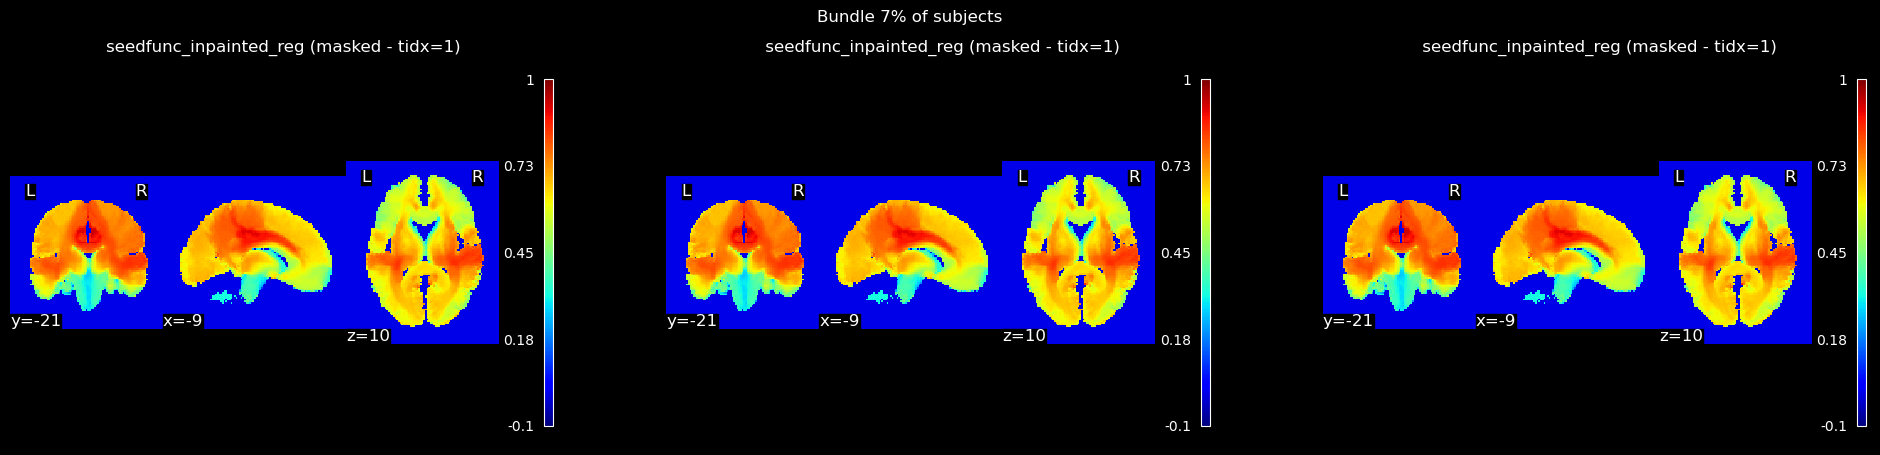

In [649]:
inpaint_mods = [seedfunc_vol_lasso, seedfunc_vol_lasso, seedfunc_vol_lasso]

all_inpaints_names = f'seedfunc_inpainted_reg (masked - tidx={1}), seedfunc_inpainted_reg (masked - tidx={1}), seedfunc_inpainted_reg (masked - tidx={1})'.split(',')

affines = [rest_affine] * 3
coords_of_interest = [(-9,-21,10)] * 3
plot_compare_inpainting(inpaint_mods, coords_of_interest, affines, all_inpaints_names, vmin=-0.1, vmax=1)

In [ ]:
# NOTE: Close the opened h5 file
hf.close()